In [73]:
import pandas as pd
import numpy as np
import sobol_seq as sob
from multi_step import multi_step_single_objective, utils
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
gpflow.config.set_default_float("float32")

In [74]:
plotGP = False
useSavedModels = False

In [75]:
def GPPlotter(stage, data, xdim, stageVar, stageOutputVar):
    ## generate indices for sampling
    xx = data.to_numpy(dtype=np.float32)[:,:xdim]
    sortedInd = np.argsort(xx[:,stageVar])
    ind = np.unique(np.random.randint(xx.shape[0], size=15))

    ## obtain the test points for prediction
    xx = xx[sortedInd[ind]]
    yy = data.to_numpy(dtype=np.float32)[sortedInd[ind],xdim:]

    ## predict mean and variance of latent GP at test points
    try:
        mean, var = stage.model.predict_f(Xnew=xx)
    except:
        xx = tf.convert_to_tensor(xx)
        mean, var = stage.model.predict_f_compiled(Xnew=xx)

    ## generate 10 samples from posterior
    tf.random.set_seed(1)  # for reproducibility
    try:
        samples = stage.model.predict_f_samples(Xnew=xx, num_samples=10)
    except:
        samples = stage.model.predict_f_samples_compiled(Xnew=xx, num_samples=10)
    # samples = samples

    ## plot
    plt.figure(figsize=(12, 6))
    plt.plot(xx[:,stageVar], yy[:,stageOutputVar], "kx", mew=2)
    plt.plot(xx[:,stageVar], mean[:,stageOutputVar], "C0", lw=2)
    plt.fill_between(
        xx[:, stageVar],
        mean[:, stageOutputVar] - 1.96 * np.sqrt(var[:, stageOutputVar]),
        mean[:, stageOutputVar] + 1.96 * np.sqrt(var[:, stageOutputVar]),
        color="C0",
        alpha=0.2,
    )

    plt.plot(xx[:,stageVar], samples[:, :, stageOutputVar].numpy().T, "C0", linewidth=0.5)

In [76]:
# Define the stage input ranges

#'T','R','Ch2so4','a-pinene','3-carene','b-pinene','time'
stage1Ranges = [[70,110],[0.15,0.35],[4,7],[0.4,0.8],[0,0.35],[0.05,0.4],[0.1,270]]
#'a-terpinene','g-terpinene','terpinolene','T','Q_liq','Q_gas','radical_initiator','time'
stage2Ranges = [[0,2],[0,2],[0,2],[80,150],[0.1,5],[5,120],[0,2],[0,240]]
# 'out_11','out_12','out_13','out_14','out_2','ox','T'
stage3Ranges = [[0,1],[0,3],[0,2],[0,2],[0,1],[0,21],[100,150]]

In [77]:
def Stage_3(inputs):
    out_3 = 71.05*(1-np.exp(-0.1657 * inputs[:,5]))*(1-np.exp(-0.2*(inputs[:,6]-100)))
    out_4 = 1.04 * out_3/100 * ( (inputs[:,3] + inputs[:,4]/100 * (inputs[:,0]+inputs[:,1]+inputs[:,2])) )
    return out_4

def sobolSequenceConditions(condition_ranges, num_points):
    """"""
    dimensions = len(condition_ranges)
    sobol_sequence = sob.i4_sobol_generate(dimensions, num_points)
    lower_bounds = np.array([condition[0] for condition in condition_ranges])
    upper_bounds = np.array([condition[1] for condition in condition_ranges])
    ranges = upper_bounds - lower_bounds
    offset = np.tile(lower_bounds,(num_points,1))
    conditions = sobol_sequence * ranges + offset
    return np.array(conditions)

# ('out_11','out_12','out_13','out_14','out_2','ox','T')
stage_3_inputs = sobolSequenceConditions(stage3Ranges,20)
stage_3_outputs = Stage_3(stage_3_inputs)

In [78]:
data_s1 = pd.read_csv('data/Stage_1.csv')
data_s2 = pd.read_csv('data/Stage_2.csv')
data_s3 = pd.DataFrame(np.concatenate((stage_3_inputs,np.expand_dims(stage_3_outputs,1)),axis=1),
          columns=['out_11','out_12','out_13','out_14','out_2','ox','T','out_3'])

In [79]:
def fit_stage(data, inputHeaders, outputHeaders):
    X = data[inputHeaders]
    Y = data[outputHeaders]
    kernel = gpflow.kernels.Matern52()
    gp = gpflow.models.GPR(data=(X,Y), kernel=kernel)
    # gpflow.utilities.print_summary(gp)
    opt = gpflow.optimizers.Scipy()
    optLogs = opt.minimize(gp.training_loss, gp.trainable_variables, options=dict(maxiter=1000))
    return gp

In [80]:
# Fit the stages
if not useSavedModels:
    data_s1 = data_s1[['T','R','Ch2so4','a-pinene','3-carene','b-pinene','time','alpha-terpinene-output',
                       'gamma-terpinene-output','terpinolene-output','p-cymene-output']]
    stage1Model = fit_stage(data_s1, inputHeaders=['T','R','Ch2so4','a-pinene','3-carene','b-pinene','time'],
                            outputHeaders=['alpha-terpinene-output','gamma-terpinene-output','terpinolene-output','p-cymene-output'])
    data_s2 = data_s2[['a-terpinene','g-terpinene','terpinolene','T','Q_liq','Q_gas','radical_initiator','time','Y2']]
    stage2Model = fit_stage(data_s2, inputHeaders=['a-terpinene','g-terpinene','terpinolene','T','Q_liq','Q_gas','radical_initiator','time'],
                            outputHeaders=['Y2'])
    data_s3 = data_s3[['out_11','out_12','out_13','out_14','out_2','ox','T','out_3']]
    stage3Model = fit_stage(data_s3, inputHeaders=['out_11','out_12','out_13','out_14','out_2','ox','T'],
                            outputHeaders=['out_3'])

In [81]:
# Save the models

# if not useSavedModels:
#     stage1Model.predict_f_compiled = tf.function(stage1Model.predict_f, input_signature=[tf.TensorSpec(shape=[None, 7], dtype=tf.float32)])
#     # stage1Model.predict_f_samples_compiled = tf.function(stage1Model.predict_f_samples,
#     #                                                      input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
#     #                                                                       tf.TensorSpec(shape=1, dtype=tf.float32),
#     #                                                                       tf.TensorSpec(shape=1, dtype=tf.bool),
#     #                                                                       tf.TensorSpec(shape=1, dtype=tf.bool)])
#     stage1Model.predict_f_samples_compiled = tf.function(stage1Model.predict_f_samples)
#     stage2Model.predict_f_compiled = tf.function(stage2Model.predict_f, input_signature=[tf.TensorSpec(shape=[None, 8], dtype=tf.float32)])
#     # stage2Model.predict_f_samples_compiled = tf.function(stage2Model.predict_f_samples, input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
#     #                                                                       tf.TensorSpec(shape=1, dtype=tf.float32),
#     #                                                                       tf.TensorSpec(shape=1, dtype=tf.bool),
#     #                                                                       tf.TensorSpec(shape=1, dtype=tf.bool)])
#     stage2Model.predict_f_samples_compiled = tf.function(stage2Model.predict_f_samples)
#     stage3Model.predict_f_compiled = tf.function(stage3Model.predict_f, input_signature=[tf.TensorSpec(shape=[None, 7], dtype=tf.float32)])
#     # stage3Model.predict_f_samples_compiled = tf.function(stage3Model.predict_f_samples, input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
#     #                                                                       tf.TensorSpec(shape=1, dtype=tf.float32),
#     #                                                                       tf.TensorSpec(shape=1, dtype=tf.bool),
#     #                                                                       tf.TensorSpec(shape=1, dtype=tf.bool)])
#     stage3Model.predict_f_samples_compiled = tf.function(stage3Model.predict_f_samples)
#
#     save_dir = './GPModels/'
#     tf.saved_model.save(stage1Model, save_dir+'Model1/')
#     tf.saved_model.save(stage2Model, save_dir+'Model2/')
#     tf.saved_model.save(stage3Model, save_dir+'Model3/')

In [82]:
# Load saved models

save_dir = './GPModels/'
if useSavedModels:
    stage1Model = tf.saved_model.load(save_dir+'Model1/')
    stage2Model = tf.saved_model.load(save_dir+'Model2/')
    stage3Model = tf.saved_model.load(save_dir+'Model3/')

In [83]:
# Generate the multi_step class
multi_step_graph = multi_step_single_objective.multi_step_output_prediction('adagrad', learning_rate=0.005, training='sobol')

In [84]:
# Load the models into the framework

#Define the stages
# stageID, stageModel, conditionRanges, followingStages (followingStageID, feedingVariables)
stage1 = utils.stage(0, stage1Model, stage1Ranges, outputDimension=9, followingStages=[[1, [0,1,2]], [2, [0,1,2,3]]])
stage2 = utils.stage(1, stage2Model, stage2Ranges[3:], outputDimension=1, followingStages=[[2,[0]]])
stage3 = utils.stage(2, stage3Model, stage3Ranges[5:], outputDimension=1)

stages = [stage1, stage2, stage3]

multi_step_graph.loadModels(stages)

c:\users\geeso\virtualenvironments\multi-step-framework\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [85]:
if plotGP == True:
    # print('Stage 1')
    # GPPlotter(stage1,data_s1,7,2,0)
    # # GPPlotter(stage2,data_s2,8,0,0)
    # print('Stage 3')
    # GPPlotter(stage3,data_s3,7,5,0)
    # print('Stage 2')
    # for i in range(8):
    #     GPPlotter(stage2,data_s2,8,i,0)
    print('Stage 3')
    for i in range(7):
        GPPlotter(stage3,data_s3,7,i,0)

In [86]:
# Define the objective functions

def objectiveFunction1(var1):
    return var1 * 10

def objectiveFunction2(*args):
    # stage1: 'T','R','Ch2so4','a-pinene','3-carene','b-pinene','time'
    # stage2: 'T','Q_liq','Q_gas','radical_initiator','time'
    # stage3: 'ox','T'

    materialUnitCosts = tf.constant([1.0,1.0,1.0,1.0,1.0,1.0])
    materialIndices = [2,3,4,5,10,12]
    timeCostConstant = 0.1
    heatingCostConstant = 0.1

    # materialAmounts = tf.concat([*args[2:6],args[10],args[12]], axis=0)
    # materialAmounts = tf.constant(args[2:6]+[args[10]]+[args[12]])

    # materialCosts = tf.tensordot(materialAmounts, materialUnitCosts, axes=1)
    # materialCosts = tf.reduce_sum(materialAmounts)
    for count, index in enumerate(materialIndices):
        try:
            materialCosts += materialUnitCosts[count] * args[index]
        except:
            materialCosts = materialUnitCosts[index] * args[index]
    timeCosts = (args[6] + args[11]) * timeCostConstant
    heatingCosts = (args[0] + args[7] + args[13]) * heatingCostConstant
    # print('Time: {}, Heat: {}, Materials: {}'.format(timeCosts,heatingCosts,materialCosts))
    return -(timeCosts + heatingCosts + materialCosts)

def objectiveFunction(*args):
    return objectiveFunction1(args[0]) - objectiveFunction2(*args[1:])

# Define the objective objects including the objective functions and the IDs of relevant variables/outputs
# Define objective variables with form: [stage, 'input'/'output', stage variable]
# objective1 = utils.objective(objectiveFunction1, [[stage3,'outputs',0]])
# objective2 = utils.objective(objectiveFunction2,[
#     [stage1,'inputs',0],[stage1,'inputs',1],[stage1,'inputs',2],[stage1,'inputs',3],[stage1,'inputs',4],[stage1,'inputs',5],[stage1,'inputs',6],
#     [stage2,'inputs',3],[stage2,'inputs',4],[stage2,'inputs',5],[stage2,'inputs',6],[stage2,'inputs',7],
#     [stage3,'inputs',5],[stage3,'inputs',6]
# ])
objective0 = utils.objective(objectiveFunction,[
    [stage3,'outputs',0],
    [stage1,'inputs',0],[stage1,'inputs',1],[stage1,'inputs',2],[stage1,'inputs',3],[stage1,'inputs',4],[stage1,'inputs',5],[stage1,'inputs',6],
    [stage2,'inputs',3],[stage2,'inputs',4],[stage2,'inputs',5],[stage2,'inputs',6],[stage2,'inputs',7],
    [stage3,'inputs',5],[stage3,'inputs',6]
])

# objectives = [objective1, objective2]
objectives = [objective0]
# objectives = [objective1]

In [87]:
# Define the objectives for the framework
multi_step_graph.defineObjectives(objectives)

In [88]:
# Train
# numStartSamples, epochs=5, h_dim=5, n_layers=4, network_type='GATConv', **kwargs
mean, objectiveRange, losses = multi_step_graph.train(30, epochs=250, h_dim=40, n_layers=1, network_type='GATConv', num_heads=3)#, activation=tf.keras.activations.relu)

Starting training
Mean:  77.10458
Range:  46.727955
Epoch: 0, Loss: 0.0922001451253891
Epoch: 1, Loss: 0.06206758692860603
Epoch: 2, Loss: 0.05765598267316818
Epoch: 3, Loss: 0.05495673790574074
Epoch: 4, Loss: 0.053212154656648636
Epoch: 5, Loss: 0.05263273045420647
Epoch: 6, Loss: 0.05121121555566788
Epoch: 7, Loss: 0.05004318058490753
Epoch: 8, Loss: 0.04877303168177605
Epoch: 9, Loss: 0.0481841079890728
Epoch: 10, Loss: 0.04784483090043068
Epoch: 11, Loss: 0.047224514186382294
Epoch: 12, Loss: 0.04689556732773781
Epoch: 13, Loss: 0.04660242423415184
Epoch: 14, Loss: 0.045842256397008896
Epoch: 15, Loss: 0.0457632876932621
Epoch: 16, Loss: 0.044882941991090775
Epoch: 17, Loss: 0.044520530849695206
Epoch: 18, Loss: 0.043347496539354324
Epoch: 19, Loss: 0.04174431413412094
Epoch: 20, Loss: 0.041304443031549454
Epoch: 21, Loss: 0.040281686931848526
Epoch: 22, Loss: 0.0392899364233017
Epoch: 23, Loss: 0.038602862507104874
Epoch: 24, Loss: 0.03842863067984581
Epoch: 25, Loss: 0.037214610

In [89]:
Actual, predicted = multi_step_graph.get_results(30, mean, objectiveRange)

30


In [90]:
print(Actual)
print(predicted)

[93.916046 85.81681  74.282745 80.11402  67.72221  70.818794 60.373085
 54.825817 97.48707  68.5358   85.71585  86.21852  66.131386 75.65757
 58.89397  62.107758 87.52198  93.559845 69.64762  76.04464  98.24412
 58.10551  85.93267  81.711075 75.2481   78.58667  61.82939  81.60385
 69.2594   80.7337  ]
[[70.42336  82.43902  70.91248  63.89554  70.530304 77.51876  65.131195
  70.684494 82.43902  67.65092  82.43902  82.43902  64.02798  67.74791
  60.0356   63.770622 75.88432  80.48226  76.719826 82.43902  82.43902
  54.61274  80.94704  79.287476 82.43902  76.287834 68.548134 82.43902
  73.18308  82.43902 ]]


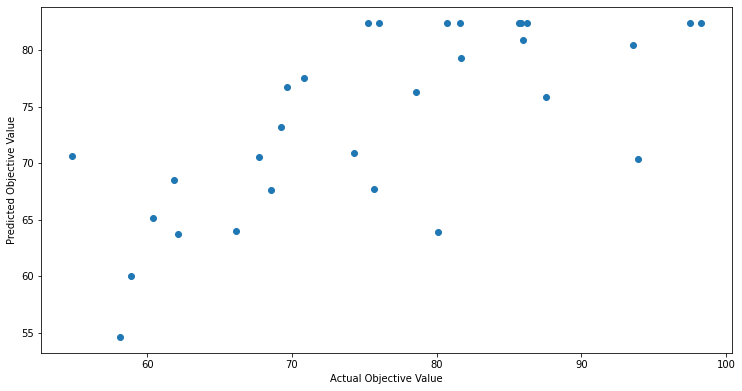

In [91]:
pareto = plt.figure(figsize=(12, 6))
ax = pareto.add_axes([0.1, 0.1, 0.8, 0.8])
ax.scatter(Actual,predicted)
# ax.set_xscale('log')
ax.set_xlabel('Actual Objective Value')
ax.set_ylabel('Predicted Objective Value')
pareto.savefig('././figures/predicted.pdf')

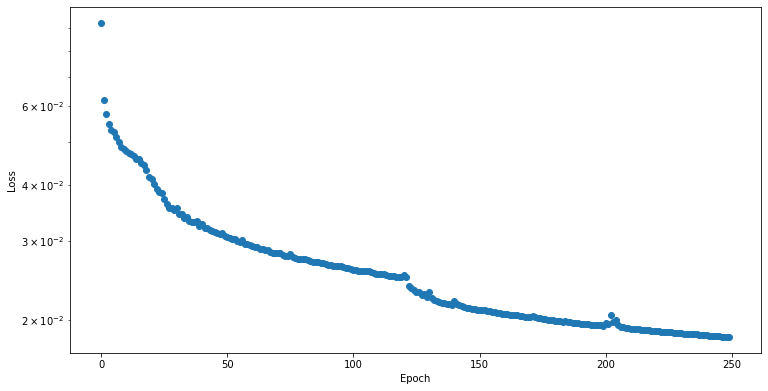

In [92]:
loss_fig = plt.figure(figsize=(12, 6))
ax = loss_fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.scatter(range(len(losses)),losses)
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
loss_fig.savefig('././figures/losses.pdf')